In [26]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict
from itertools import repeat, combinations
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

In [27]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols, insert_row_number, plot_train_test_distribution
)
from utils.extraction_helpers import read_file
from utils.feature_group import CATEGORY_COLUMNS

In [28]:
from feature_engineering_helpers import feature_gen_pipeline

In [29]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
pandarallel.initialize(nb_workers=16, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [31]:
START = time.time()

In [32]:
def combine_binary_features(train, test, final_col_name, col_list, sufficient_count=500, drop_ori=False):
    train["temp"] = train[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    test["temp"] = test[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    le = LabelEncoder()
    le.fit(train["temp"])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df = train.groupby("temp").agg(
        target_count=("target", "count")
    )
    less_count_cat_codes = train_df.loc[train_df["target_count"] < sufficient_count].index.tolist()
    le_dict = {k: v if k not in less_count_cat_codes else np.nan for k, v in le_dict.items()}
    train[final_col_name] = train["temp"].map(le_dict).astype("category")
    test[final_col_name] = test["temp"].map(le_dict).astype("category")
    if drop_ori:
        train.drop(columns=col_list, inplace=True)
        test.drop(columns=col_list, inplace=True)
    return train, test

### Read Data

In [8]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [9]:
%%time
train = read_file(f"../{INTERIM_DATA_PATH}/v3/train_parquet/train_all_variables.parquet")
test1 = read_file(f"../{INTERIM_DATA_PATH}/v3/test_parquet/test_all_variables1.parquet")
test2 = read_file(f"../{INTERIM_DATA_PATH}/v3/test_parquet/test_all_variables2.parquet")

Shape of data: (5531451, 200)
Shape of data: (5681079, 199)
Shape of data: (5682683, 199)
CPU times: user 17.6 s, sys: 29.9 s, total: 47.5 s
Wall time: 42.1 s


In [10]:
test = pd.concat([test1, test2], ignore_index=True)
del test1, test2

In [11]:
gc.collect()

18

In [12]:
df_list = [train, test]

In [13]:
for df in df_list:
    df["D_135"] = df["D_135"].fillna(-1)
    df["D_137"] = df["D_137"].fillna(-1)

In [14]:
%%time
n = train.nunique()
binary_features = n[n == 2].index.tolist()

CPU times: user 4.05 s, sys: 1.15 s, total: 5.2 s
Wall time: 7.26 s


### Group Features

### Risk Binary

In [15]:
risk_binary_features = [c for c in binary_features if c.startswith("R_")]

In [16]:
sparse_risk_binary_features = train.loc[:, risk_binary_features].sum().sort_values().iloc[:13].index.tolist()
print(sorted(sparse_risk_binary_features))

['R_13', 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_28']


In [17]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="R_binaries", 
    col_list=sparse_risk_binary_features, 
    sufficient_count=300, 
    drop_ori=True
)

CPU times: user 1min 12s, sys: 36.3 s, total: 1min 48s
Wall time: 2min 50s


Train-Public PSI: 0.0017, Train-Private PSI: 0.0017


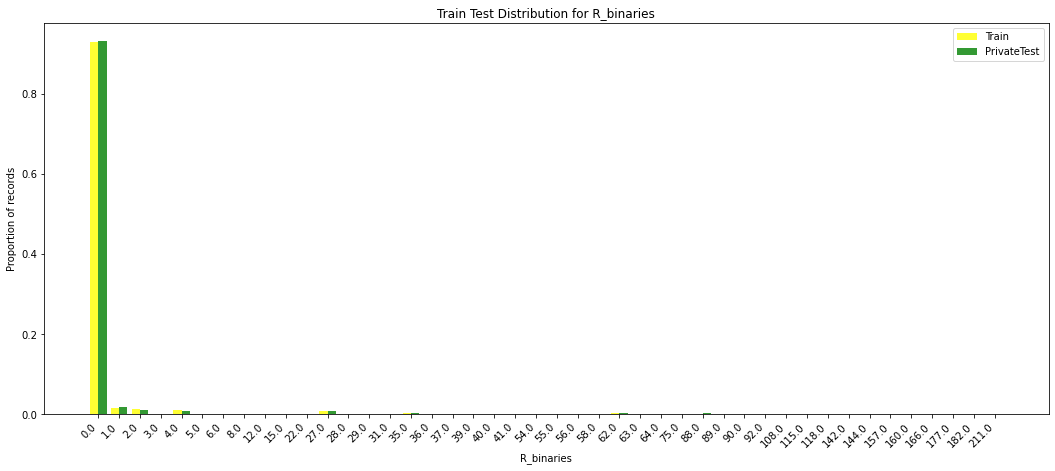

In [18]:
plot_train_test_distribution([train, test], "R_binaries", without_drop_tail=True, is_category=True)

In [19]:
train.shape, test.shape

((5531451, 189), (11363762, 188))

### Spend Binary

In [20]:
spend_binary_features = [c for c in binary_features if c.startswith("S_")]
print(spend_binary_features)

['S_6', 'S_16', 'S_18', 'S_20']


In [21]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="S_binaries", 
    col_list=spend_binary_features, 
    sufficient_count=300
)

CPU times: user 23.1 s, sys: 16.3 s, total: 39.4 s
Wall time: 1min 1s


Train-Public PSI: 0.0090, Train-Private PSI: 0.0090


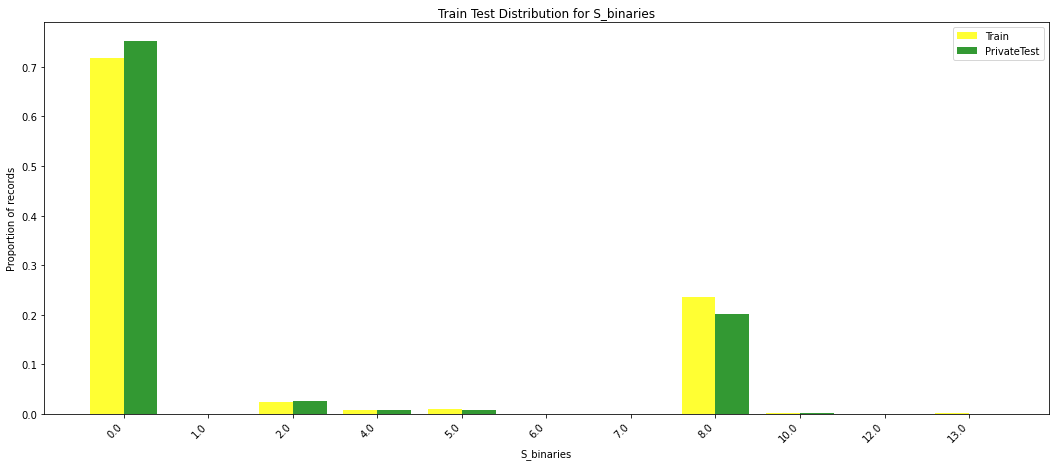

In [22]:
plot_train_test_distribution([train, test], "S_binaries", without_drop_tail=True, is_category=True)

### Balance Binary

In [23]:
balance_binary_features = [c for c in binary_features if c.startswith("B_")]
print(balance_binary_features)

['B_8', 'B_27', 'B_32', 'B_33', 'B_36']


In [34]:
sparse_balance_binary_features = balance_binary_features

In [35]:
for col in sparse_balance_binary_features:
    print(train.groupby(col)['target'].mean())

B_8
0.0    0.123307
1.0    0.405050
Name: target, dtype: float64
B_27
0    0.248804
1    0.837016
Name: target, dtype: float64
B_32
0    0.242399
1    0.541201
Name: target, dtype: float64
B_33
0.0    0.492619
1.0    0.091494
Name: target, dtype: float64
B_36
0    0.247365
1    0.561208
Name: target, dtype: float64


In [36]:
%%time
train, test = combine_binary_features(
    train, 
    test, 
    final_col_name="B_binaries", 
    col_list=balance_binary_features, 
    sufficient_count=500,
    drop_ori=True
)

CPU times: user 28.7 s, sys: 23.3 s, total: 51.9 s
Wall time: 1min 11s


Train-Public PSI: 0.0159, Train-Private PSI: 0.0159


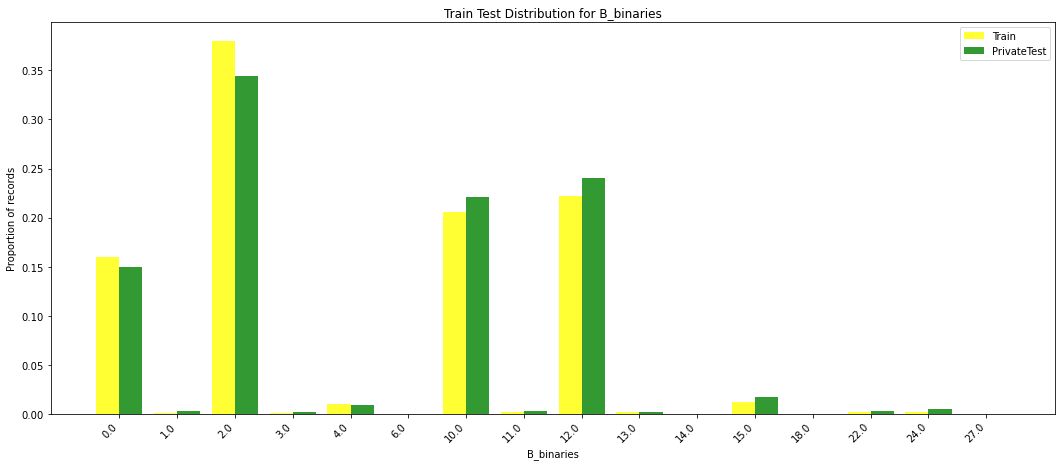

In [37]:
plot_train_test_distribution([train, test], "B_binaries", without_drop_tail=True, is_category=True)

In [38]:
train.shape, test.shape

((5531451, 186), (11363762, 185))

### Delinquency Binaries

In [39]:
delinquency_binary_features = [c for c in binary_features if c.startswith("D_")]
print(delinquency_binary_features)

['D_54', 'D_66', 'D_86', 'D_87', 'D_93', 'D_94', 'D_96', 'D_103', 'D_109', 'D_114', 'D_116', 'D_120', 'D_127', 'D_128', 'D_129', 'D_130', 'D_139', 'D_140', 'D_143']


In [40]:
sparse_delinquency_binary_features = train.loc[:, delinquency_binary_features].sum().sort_values().iloc[:8].index.tolist()
print(sorted(sparse_delinquency_binary_features))

['D_109', 'D_116', 'D_140', 'D_86', 'D_87', 'D_93', 'D_94', 'D_96']


In [41]:
# for col in sparse_delinquency_binary_features:
#     print(train.groupby(col)['target'].mean())

In [42]:
# %%time
# train, test = combine_binary_features(
#     train, 
#     test, 
#     final_col_name="D_binaries", 
#     col_list=sparse_delinquency_binary_features, 
#     sufficient_count=500,
#     drop_ori=True
# )

In [43]:
# plot_train_test_distribution([train, test], "D_binaries", without_drop_tail=True, is_category=True)

In [44]:
train.shape, test.shape

((5531451, 186), (11363762, 185))

In [45]:
train.to_parquet("./merged_train.parquet")
test.to_parquet("./merged_test.parquet")

### Aggregation

In [47]:
cat_cols = list(set(get_cols(train, "_binaries")).union(get_cols(train, CATEGORY_COLUMNS)))
print(cat_cols)

['D_120', 'D_114', 'S_binaries', 'R_binaries', 'D_63', 'B_binaries', 'D_68', 'D_92', 'D_116', 'D_126', 'B_30', 'D_117', 'B_38', 'D_64']


- Keep a record of categorical variables for future use

#### Train

In [48]:
%%time
train = read_file("./merged_train.parquet")

Shape of data: (5531451, 186)
CPU times: user 5.65 s, sys: 8.21 s, total: 13.9 s
Wall time: 8.85 s


In [49]:
%%time
train_agg, keep_column = feature_gen_pipeline(train)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:49<00:00,  3.38it/s]

CPU times: user 3min 47s, sys: 42.7 s, total: 4min 30s
Wall time: 4min 49s


In [50]:
train_agg["target"] = labels["target"].values
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 14.137221817 GB, Shape: (458913, 5068)


In [51]:
float64_columns = train_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = train_agg[col].astype(np.float32).values
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2628/2628 [00:32<00:00, 80.51it/s]


In [52]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.382883137 GB, Shape: (458913, 5068)


In [53]:
number_columns = train_agg.select_dtypes(np.number).columns.tolist()
for col in tqdm(number_columns):
    temp = train_agg[col].round(3)
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].round(3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5012/5012 [00:18<00:00, 266.58it/s]


In [54]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.382883137 GB, Shape: (458913, 5068)


In [55]:
%%time
train_agg = train_agg.loc[:, keep_column]

In [56]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 8.760597109 GB, Shape: (458913, 4732)


In [57]:
train_agg.to_parquet(f"./train_agg.parquet")

In [58]:
del train_agg, train

### Test 1

In [59]:
%%time
test = read_file("./merged_test.parquet")

Shape of data: (11363762, 185)
CPU times: user 11.6 s, sys: 17.6 s, total: 29.2 s
Wall time: 22.8 s


In [60]:
test1 = test.iloc[:5681884]
test2 = test.iloc[5681884:]

In [61]:
del test
del test2

In [62]:
%%time
test_agg, keep_column = feature_gen_pipeline(test1)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:50<00:00,  3.28it/s]

CPU times: user 3min 48s, sys: 44.6 s, total: 4min 32s
Wall time: 4min 51s


In [63]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 16.026800531 GB, Shape: (462379, 5067)


In [64]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3594/3594 [01:00<00:00, 59.86it/s]


In [65]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.473965343 GB, Shape: (462379, 5067)


In [66]:
test_agg = test_agg.loc[:, keep_column]

In [67]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.848828935 GB, Shape: (462379, 4732)


In [68]:
test_agg.to_parquet(f"./test_agg1.parquet")

In [69]:
del test_agg

### Test 2

In [70]:
%%time
test = read_file("./merged_test.parquet")

Shape of data: (11363762, 185)
CPU times: user 11.6 s, sys: 18.6 s, total: 30.1 s
Wall time: 23.7 s


In [71]:
test1 = test.iloc[:568184]
test2 = test.iloc[5681884:]

In [72]:
del test
del test1

In [73]:
test = test2.copy()
del test2

In [74]:
%%time
test_agg, keep_column = feature_gen_pipeline(test)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Skewness done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:50<00:00,  3.30it/s]

CPU times: user 3min 49s, sys: 40 s, total: 4min 29s
Wall time: 4min 53s


In [75]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 16.022056906 GB, Shape: (462242, 5067)


In [76]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3594/3594 [01:00<00:00, 59.63it/s]


In [77]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.434183922 GB, Shape: (462242, 5067)


In [78]:
%%time
test_agg = test_agg.loc[:, keep_column]

CPU times: user 1.36 s, sys: 9.14 s, total: 10.5 s
Wall time: 22 s


In [79]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.812930674 GB, Shape: (462242, 4732)


In [80]:
test_agg.to_parquet(f"./test_agg2.parquet")

In [81]:
del test_agg

### END

In [82]:
END = time.time()

In [83]:
print(f"{END - START:.2f} seconds elapsed")

1533.98 seconds elapsed


### Prepare final features for training

In [93]:
def select_bad_features(feature_imp_df, threshold):
    bad_features = []
    feature_imp_df = feature_imp_df.fillna(0)
    for type_ in feature_imp_df.columns[1:]:
        bad_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return bad_features

In [94]:
def select_good_features(feature_imp_df, threshold):
    good_features = []
    for type_ in feature_imp_df.columns[1:]:
        good_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] >= threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return good_features

### Train

In [85]:
%%time
train_agg = read_file(f"./train_agg.parquet")

Shape of data: (458913, 4733)
CPU times: user 17.2 s, sys: 22.7 s, total: 39.9 s
Wall time: 29.2 s


In [87]:
train_agg.head(3)

,customer_ID,S_27_general_trend,D_56_previous_sprint,B_19_ma2_r1_r3,D_66_last_first_ratio,D_61_ma3_r2,D_115_last_minus_ma2_r2,D_81_sprint,S_13_ma2_r3,D_66_distortion,...,B_25_ma2_r3,R_16_last_minus_avg,B_21_range,S_20_ma2_r1_r2,R_7_ma2_r1_r3,S_22a_ma2_r2,R_27_last_first_ratio,D_53_ma2_r2,D_91_distortion,S_22a_general_trend
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.153846,0.00,NaN,NaN,0.175000,0.00,0.0,10.0,NaN,...,0.000,0.000000,0,NaN,NaN,0.90,1.0,NaN,1.063636,0.019231
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,-0.126923,0.01,NaN,NaN,0.023333,0.01,0.0,NaN,NaN,...,0.005,-0.076923,0,NaN,NaN,0.88,1.0,NaN,5.801653,0.046154
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,NaN,0.01,NaN,NaN,0.106667,0.00,0.0,NaN,NaN,...,0.000,0.000000,0,NaN,NaN,NaN,1.0,NaN,0.000000,NaN


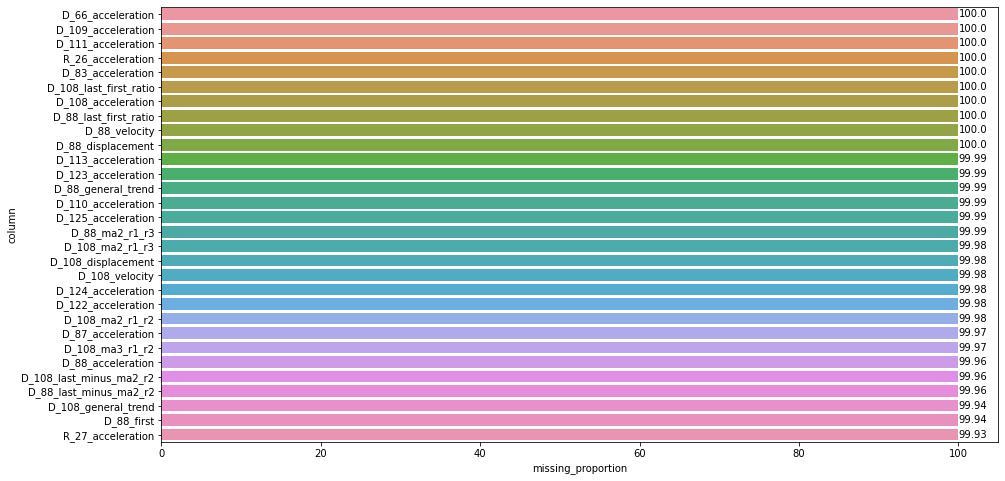

CPU times: user 2.83 s, sys: 502 ms, total: 3.33 s
Wall time: 3.14 s


In [89]:
%%time
m = plot_missing_proportion_barchart(train_agg)

In [90]:
high_missing_columns = m.loc[m["missing_proportion"] > 98.5]["column"].tolist()
len(high_missing_columns)

223

In [91]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 522 ms, sys: 2.61 s, total: 3.14 s
Wall time: 5.85 s


In [92]:
train_agg.shape

(458913, 4510)

In [95]:
summary_feature_imp3 = read_file(f"../{EXP_PATH}/3.lgbm_dart_5197/feature_importance.csv")
summary_feature_imp5 = read_file(f"../{EXP_PATH}/5.lgbm_dart_923_half_fix/feature_importance.csv")

Shape of data: (166, 24)
Shape of data: (181, 39)


In [96]:
median_fi3 = summary_feature_imp3.median().median()
median_fi5 = summary_feature_imp5.median().median()
median_fi3, median_fi5

(130.2, 106.5)

In [97]:
bad_features = list(
    set(select_bad_features(summary_feature_imp3, median_fi3))
    .intersection(select_bad_features(summary_feature_imp5, median_fi5))
    .intersection(train_agg.columns)
)
len(bad_features)

1604

In [98]:
train_agg.shape

(458913, 4510)

In [99]:
%%time
train_agg = train_agg.drop(columns=bad_features)

CPU times: user 258 ms, sys: 1.77 s, total: 2.03 s
Wall time: 3.08 s


In [105]:
train_agg.shape

(458913, 2906)

In [106]:
train_agg.to_parquet(f"./final_train_agg.parquet")

In [109]:
final_columns = train_agg.columns.tolist()

In [107]:
final_cat_columns = get_cols(train_agg, cat_cols)
print(final_cat_columns)

['D_114_last', 'S_binaries_last', 'D_68_second_last', 'B_30_third_last', 'D_116_third_last', 'B_38_second_last', 'D_92_first', 'D_117_last', 'S_binaries_third_last', 'D_92_third_last', 'D_64_second_last', 'S_binaries_first', 'D_120_last', 'R_binaries_third_last', 'D_64_last', 'B_38_last', 'D_64_third_last', 'B_binaries_second_last', 'B_38_first', 'D_68_last', 'D_116_second_last', 'D_92_last', 'D_116_first', 'D_68_first', 'D_68_third_last', 'R_binaries_last', 'D_126_third_last', 'D_92_second_last', 'B_binaries_third_last', 'R_binaries_first', 'D_117_second_last', 'D_114_third_last', 'D_117_third_last', 'D_63_third_last', 'B_binaries_first', 'D_120_third_last', 'D_117_first', 'B_binaries_last', 'D_116_last', 'B_38_third_last', 'R_binaries_second_last', 'S_binaries_second_last', 'D_114_second_last']


In [110]:
del train_agg

### Test

In [111]:
%%time
test_agg1 = read_file(f"./test_agg1.parquet")
test_agg2 = read_file(f"./test_agg2.parquet")

Shape of data: (462379, 4732)
Shape of data: (462242, 4732)
CPU times: user 31.4 s, sys: 39.9 s, total: 1min 11s
Wall time: 1min


In [112]:
test_agg = pd.concat([test_agg1, test_agg2], ignore_index=True)
del test_agg1, test_agg2

In [119]:
test_columns = list(set(final_columns).intersection(test_agg.columns))

In [120]:
len(final_columns), len(test_columns)

(2906, 2905)

In [122]:
%%time
test_agg = test_agg.loc[:, test_columns]

CPU times: user 2.17 s, sys: 18.6 s, total: 20.7 s
Wall time: 1min 33s


In [ ]:
%%time
test_agg.to_parquet(f"./final_test_agg.parquet")